# Forecasting of the "machine learning" searched on googled per month using a dummy model

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm
import warnings

In [2]:
warnings.filterwarnings("ignore")

## Data Loading

In [3]:
df = pd.read_csv('data/machine_learning_trend.csv', header=1)

In [4]:
df.columns = ['date', 'ml']
df['date'] = pd.to_datetime(df.date)
df.set_index('date', inplace=True)

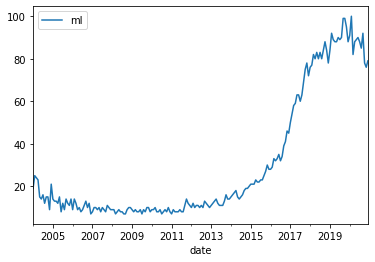

In [5]:
df.plot();

As we can see, we have a strong trend.

In [6]:
df.ml.describe()

count    204.000000
mean      29.789216
std       29.667612
min        7.000000
25%        9.000000
50%       14.000000
75%       39.500000
max      100.000000
Name: ml, dtype: float64

Above, we can see various information on our variable : the median value is 14 and the mean about 30.

So, when looking at the error rate, we can put it in perspective of the actual value given above.

### Autocorrelation

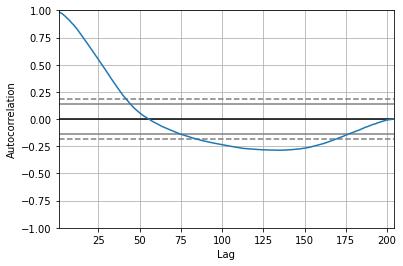

In [7]:
pd.plotting.autocorrelation_plot(df.ml);

As we can see on the figure above, the previous values have a very strong autocorelation with the current values.

Also, there doesn't seem to be any kind of seasonality visible at this point.

### Visualisation

In [8]:
decomposition = seasonal_decompose(df.ml);

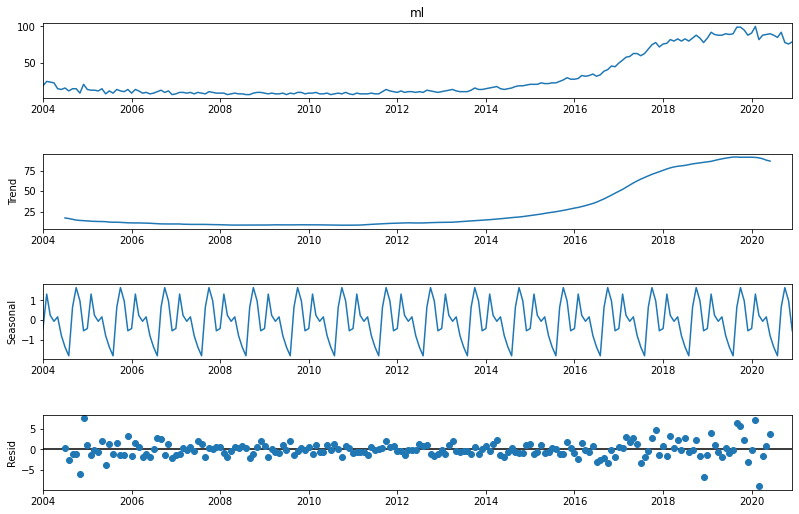

In [9]:
fig = decomposition.plot()
fig.set_size_inches(12, 8);

On the figure above, we have decomposed our data in three variables : trend, seasonality and resids.

They if they are combined, we get the original data :  
`ml = trend + seasonal + resid`

As we can see, the trend values range is much more important than the seasonal or resid aspect of our data, it means that it is the main aspect that we should try to represent.

### Dummy model

Like for the "foie gras", we're going to make a naive model using the data from 12 months ago as a prediction.

In [10]:
df_dummy = df.copy()
df_dummy['naive_prediction'] = df_dummy['ml'].shift(12)
df_dummy.dropna(inplace=True)

In [11]:
size = int(len(df_dummy) * 0.66)
train, test = df_dummy[0:size], df_dummy[size:len(df_dummy)]

In [12]:
mse = mean_squared_error(test.ml, test.naive_prediction)
mae = mean_absolute_error(test.ml, test.naive_prediction)
r2 = r2_score(test.ml, test.naive_prediction)
print(f'\n\t-> mse {mse}\n\t-> mae {mae}\n\t-> r2 {r2}')


	-> mse 277.3484848484849
	-> mae 14.227272727272727
	-> r2 0.5181913061233768


As we can see this naive prediction is **very** bad this time, the MAE is about 14, and we know that the median value is also 14, so it is not good.

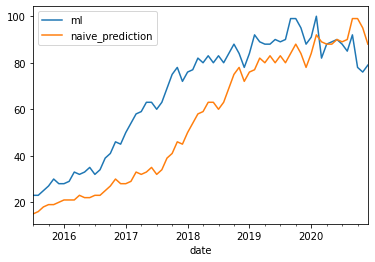

In [13]:
test[['ml', 'naive_prediction']].plot()
plt.show()

On the figure above, we can see that our prediction follow the trend, but just too late.

### ARIMA Model

In [14]:
model = auto_arima(train.ml, seasonal=False)
model

ARIMA(order=(4, 2, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [15]:
predictions = model.predict(len(test))

In [16]:
test = test.assign(arima_prediction=predictions)

In [17]:
mse = mean_squared_error(test.ml, test.arima_prediction)
mae = mean_absolute_error(test.ml, test.arima_prediction)
r2 = r2_score(test.ml, test.arima_prediction)
print(f'\n\t-> mse {mse}\n\t-> mae {mae}\n\t-> r2 {r2}')


	-> mse 1084.9565199320587
	-> mae 28.749191413197906
	-> r2 -0.8847821868108083


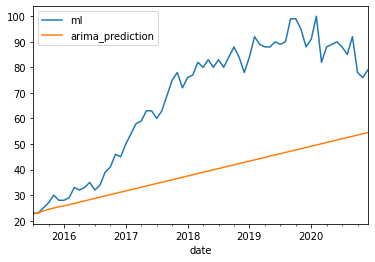

In [18]:
test[['ml', 'arima_prediction']].plot()
plt.show()

#### Rolling forecasts 7 day window

In [19]:
parameters = {'order': (4, 2, 2), 'with_intercept': False} # obtained with auto_arima previously

In [20]:
class ARIMAModel():
    
    def __init__(self):
        self.model = None
    
    def train(self, data: pd.Series, **kwargs):
        self.model = ARIMA(data, order=kwargs['order']).fit()
        
    def predict(self, duration: int) -> pd.Series:
        return self.model.forecast(steps=duration)
    
    @classmethod
    def rolling_forecast(cls, parameters: dict, train: pd.DataFrame, test: pd.DataFrame, window: int = 7) -> dict:
        history = train.copy()
        predictions = None
        for test_index in tqdm(range(0, len(test), window)):
            m = cls()
            m.train(data=history.ml,
                    **parameters
                   ) 
            new_predictions = m.predict(window)
            if predictions is None:
                predictions = new_predictions
            else:
                predictions = pd.concat([predictions, new_predictions])
            history = history.append([test[test_index: test_index + window]])
        return predictions

In [21]:
rolling_predictions = ARIMAModel.rolling_forecast(parameters, train, test)

100%|██████████| 10/10 [00:02<00:00,  4.75it/s]


In [22]:
test = test.assign(rolling_predictions=rolling_predictions)

In [23]:
mse = mean_squared_error(test.ml, test.rolling_predictions)
mae = mean_absolute_error(test.ml, test.rolling_predictions)
r2 = r2_score(test.ml, test.rolling_predictions)
print(f'\n\t-> mse {mse}\n\t-> mae {mae}\n\t-> r2 {r2}')


	-> mse 58.90431940927817
	-> mae 6.120834541149357
	-> r2 0.8976716486705163


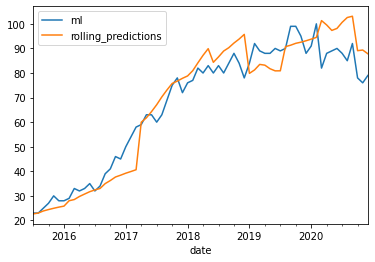

In [24]:
test[['ml', 'rolling_predictions']].plot()
plt.show()

When using rolling forecasts, we can see that we get our best performances yet : a MAE of 6.1 ! 

#### Rolling forecast 1 day window

When using rolling forecasts, we can see that we get our best performances yet : a MAE of 6.1 ! 

In [25]:
rolling_predictions = ARIMAModel.rolling_forecast(parameters, train, test, 1)

100%|██████████| 66/66 [00:14<00:00,  4.62it/s]


In [26]:
test = test.assign(rolling_predictions_1_day=rolling_predictions)

In [27]:
mse = mean_squared_error(test.ml, test.rolling_predictions_1_day)
mae = mean_absolute_error(test.ml, test.rolling_predictions_1_day)
r2 = r2_score(test.ml, test.rolling_predictions_1_day)
print(f'\n\t-> mse {mse}\n\t-> mae {mae}\n\t-> r2 {r2}')


	-> mse 35.968340571507646
	-> mae 3.6298945911620026
	-> r2 0.9375159406364346


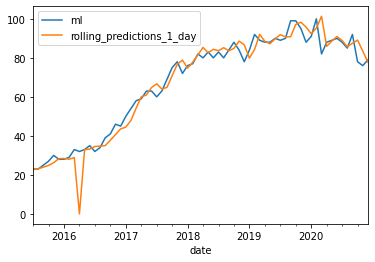

In [28]:
test[['ml', 'rolling_predictions_1_day']].plot()
plt.show()

En utilisant un rolling forecast sur une période plus courte (1 jour), on obtient des résultats encore plus performant : un MAE de 3.6 (quasiment moitié moins que précédemment).

Visuellement parlant, on peut voir un pic de prédiction qui est inférieur à ce que nous attendions.

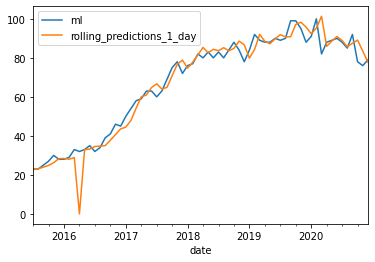

In [30]:
test[['ml', 'rolling_predictions_1_day']].plot()
plt.show()